# 6 SQL Tricks Every Data Scientist Should Know

## Part 1 of SQL tricks to make your analytics work more efficient

In [1]:
from IPython.core.display import HTML
# HTML("""
# <style>

# div.cell { /* Tunes the space between cells */
# margin-top:1em;
# margin-bottom:1em;
# }

# div.text_cell_render h1 { /* Main titles bigger, centered */
# font-size: 1.8em;
# line-height:1.4em;
# text-align:center;
# }

# div.text_cell_render h2 { /*  Parts names nearer from text */
# margin-bottom: -0.4em;
# }


# div.text_cell_render { /* Customize text cells */
# font-family: 'Times New Roman';
# font-size:1.5em;
# line-height:1.4em;
# padding-left:2em;
# padding-right:2em;
# }
# </style>
# """)  

# HTML("""
# <style>

# div.cell { /* Tunes the space between cells */
# margin-top:0.5em;
# margin-bottom:0.5em;
# }

# div.text_cell_render h1 { /* Main titles bigger, centered */
# font-size: 1.8em;
# line-height:1.4em;
# text-align:center;
# }

# div.text_cell_render h2 { /*  Parts names nearer from text */
# margin-bottom: -0.4em;
# }

# div.text_cell_render { /* Customize text cells */
# font-family: 'Times New Roman';
# font-size:1.5em;
# line-height:1.4em;
# }

# /* Change global font size (for code) */
# .CodeMirror {
# font-size: 16px !important;
# font-family: monospace;
# }

# </style>
# """) 

Data scientists/analysts should know SQL, in fact, all professionals working with data and analytics should know SQL. To some extent, SQL is an under-rated skill for data science because it has been taken for granted as a necessary yet uncool way of extracting data out from the database to feed into pandas and {tidyverse} — fancier ways to wrangle your data.

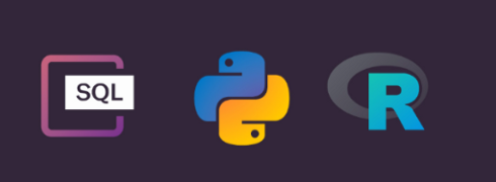


However, with massive data being collected and churned out every day in the industries, as long as the data reside in a SQL compliant database, SQL is still the most proficient tool to help you investigate, filter and aggregate to get a thorough understanding of your data. By slicing and dicing with SQL, analysts are allowed to possibly identify patterns that worth further looking into, which oftentimes leads to redefining the analysis population and variables to be considerably smaller (than the initial scope).

Hence rather than transferring huge datasets into Python or R, the first step of analytics should be using SQL to gain informative insights from our data.

Working in real-world relational databases, SQL is way more than just SELECT, JOIN, ORDER BY statements. In this blog, I will discuss 6 tips (and one Bonus tip) to make your analytics work more efficient with SQL and its integrating with other programming languages like Python and R.

For this exercise, we will work with Oracle SQL on the toy data table below, which consists of multiple types of data elements,

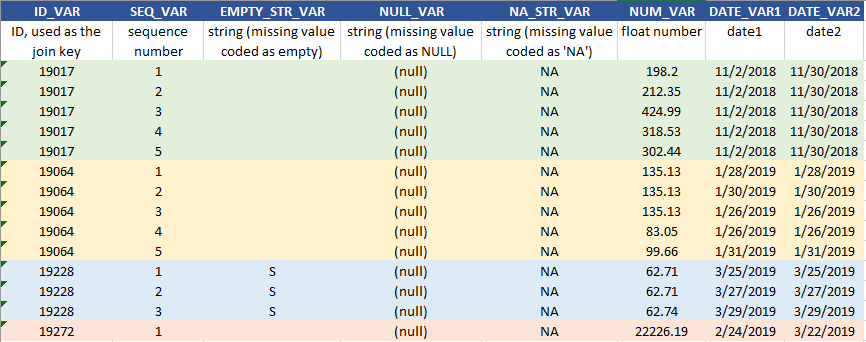

### 1. COALESCE() to recode NULL / missing data

When it comes to re-coding missing values, the COALESCE() function is our secret sauce, which, under this circumstance, re-codes the NULL to whatever value specified in the second argument. For our example, we can re-code the NULL_VAR to a character value 'MISSING',

```mysql
/** 1) COALESCE() to recode the NULL value to the character string MISSING **/
SELECT 
    ID_VAR, 
    NULL_VAR,
    COALESCE(NULL_VAR, 'MISSING') AS RECODE_NULL_VAR
FROM  
  CURRENT_TABLE    
ORDER BY ID_VAR
```

this code snippet returns,

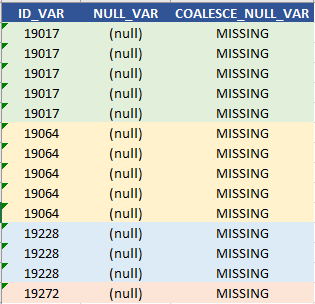

One important note, however, is that in databases, missing values can be encoded in various ways besides NULL. For instance, they could be empty string/blank space (e.g., EMPTY_STR_VAR in our table), or a character string 'NA' (e.g., NA_STR_VAR in our table). In these cases, COALESCE( ) would not work, but they can be handled with the CASE WHEN statement,

```mysql
/** However, COALESCE() NOT WORK for Empty or NA string, instead, use CASE WHEN **/
SELECT 
  ID_VAR, 
  EMPTY_STR_VAR, 
  COALESCE(EMPTY_STR_VAR, 'MISSING') AS COALESCE_EMPTY_STR_VAR, 
  CASE WHEN EMPTY_STR_VAR = ' ' THEN 'EMPTY_MISSING' END AS CASEWHEN_EMPTY_STR_VAR, 
  
  NA_STR_VAR, 
  CASE WHEN NA_STR_VAR = 'NA' THEN 'NA_MISSING' END AS CASEWHEN_NA_STR_VAR
FROM 
  CURRENT_TABLE 
ORDER BY ID_VAR
```

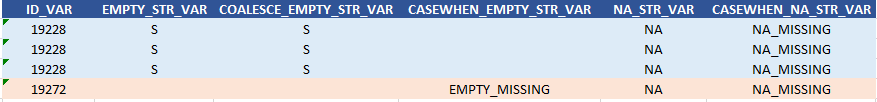

### 2. Compute running total and cumulative frequency

Running total can be useful when we are interested in the total sum (but not individual value) at a given point for potential analysis population segmentation and outlier identification.
The following showcases how to calculate the running total and cumulative frequency for the variable NUM_VAR,

```mysql
/** 2) Running total/frequency **/
SELECT
  DAT.NUM_VAR, 
  SUM(NUM_VAR) OVER (PARTITION BY JOIN_ID) AS TOTAL_SUM,
  ROUND(CUM_SUM / SUM(NUM_VAR) OVER (PARTITION BY JOIN_ID), 4) AS CUM_FREQ
FROM 
(
  SELECT 
	 T.*, 
	 SUM(NUM_VAR) OVER (ORDER BY NUM_VAR ROWS UNBOUNDED PRECEDING) AS CUM_SUM, 
	 CASE WHEN ID_VAR IS NOT NULL THEN '1' END AS JOIN_ID
  FROM CURRENT_TABLE    T
) DAT 	
ORDER BY CUM_FREQ
```

Here is our output, 

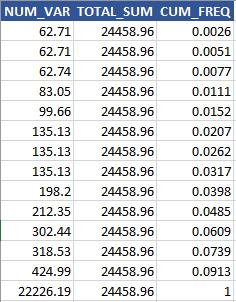

Two tricks here, (1) SUM over ROWS UNBOUNDED PRECEDING will calculate the sum of all prior values to this point; (2) create a JOIN_ID to calculate the total sum.

We use the window function for this calculation, and from the cumulative frequency, it is not hard to spot the last record as an outlier.

### 3. Find the record(s) with extreme values without self joining

So our task is to return the row(s) with the largest NUM_VAR value for each unique ID. An intuitive query is to first find the max value for each ID using group by, and then self join on ID and the max value. Yet a more concise way would be,

```mysql
/** 3) Find the record having a number calculated by analytic functions (e.g., MAX) without self-joining **/
SELECT *
FROM 
(
  SELECT 
    DAT.*, 
    CASE WHEN (NUM_VAR = MAX(NUM_VAR) OVER (PARTITION BY ID_VAR)) THEN 'Y' ELSE 'N' END AS MAX_NUM_IND
  FROM 
    CURRENT_TABLE     DAT
) DAT2
WHERE MAX_NUM_IND = 'Y'
```

this query should give us the following output, showing rows having the max NUM_VAR grouped by ID,

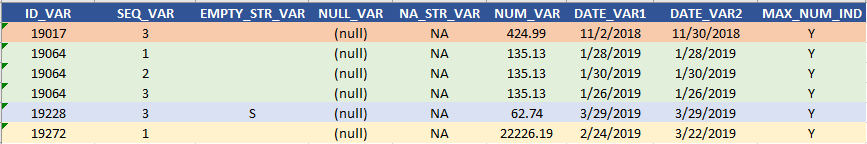

### 4. Conditional WHERE clause

Everyone knows the WHERE clause in SQL for subsetting. In fact, I find myself using conditional WHERE clause more often. With the toy table, for instance, we want only to keep the rows satisfying the following logic,

- if SEQ_VAR in (1, 2, 3) & diff(DATE_VAR2, DATE_VAR1)≥ 0

- elif SEQ_VAR in (4, 5, 6) & diff(DATE_VAR2, DATE_VAR1) ≥1

- else diff(DATE_VAR2, DATE_VAR1) ≥2

Now the conditional WHERE clause comes in handy,

```mysql
/** 4) Conditional where clause **/
SELECT 
  DAT.ID_VAR,
  DAT.SEQ_VAR,
  DAT.NUM_VAR,
  DATE_VAR1, 
  DATE_VAR2,
  TRUNC(DATE_VAR2) - TRUNC(DATE_VAR1) AS LAG_IN_DATES
FROM 
  CURRENT_TABLE      DAT 
WHERE
  (TRUNC(DATE_VAR2) - TRUNC(DATE_VAR1)) >= CASE WHEN SEQ_VAR IN (1,2,3) THEN 0 WHEN SEQ_VAR IN (4,5,6) THEN 1 ELSE 2 END 
ORDER BY ID_VAR, SEQ_VAR
```

The logic aforementioned should eliminate the sequences 4, 5 of ID = 19064 because the difference between date2 and date1 = 0, and this is exactly what the query returns below, 


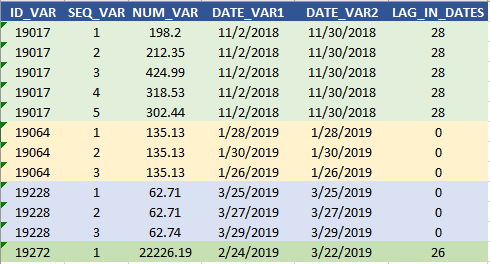

### 5. Lag() and Lead() to work with consecutive rows

Lag (looking at the previous row) and Lead (looking at the next row) probably are two of the most used [analytic functions](https://oracle-base.com/articles/misc/analytic-functions#using_analytic_functions) in my day-to-day work. In a nutshell, these two functions allow users to query more than one row at a time without self-joining. More detailed explanations can be found [here](https://www.techonthenet.com/oracle/functions/lag.php).

Let's say, we want to compute the difference in NUM_VAR between two consecutive rows (sorted by sequences),


```mysql
/** 5) LAG() or LEAD() function **/
SELECT
 DAT.ID_VAR,
 DAT.SEQ_VAR,
 DAT.NUM_VAR,
 NUM_VAR - PREV_NUM AS NUM_DIFF	
FROM 
(
	SELECT 
	 T.*, 
	 LAG(NUM_VAR, 1, 0) OVER (PARTITION BY ID_VAR ORDER BY SEQ_VAR) AS PREV_NUM        
	FROM 
	 CURRENT_TABLE     T
)  DAT
ORDER BY ID_VAR, SEQ_VAR
```

The LAG() function returns the prior row, and if there is none (i.e., the first row of each ID), the PREV_NUM is coded as 0 to compute the difference shown as NUM_DIFF below,



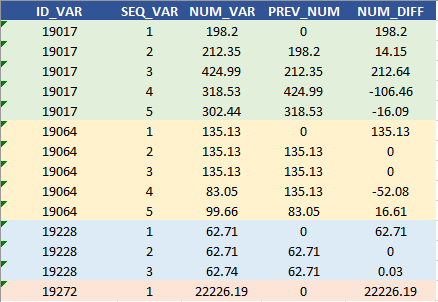


### 6. Integrate SQL query with Python and R

The prerequisite of integrating SQL queries into Python and R is to establish the database connections via ODBC or JDBC. Since this is beyond the scope of this blog, I will not discuss it here, however, more details regarding how to (create ODBC or JDBC connections) can be found [here](https://medium.com/).

Now, assuming that we already connected Python and R to our database, the most straightforward way of using query in, say Python, is to copy and paste it as a string, then call pandas.read_sql(),

```mysql
my_query = "SELECT * FROM CURRENT_TABLE"
sql_data = pandas.read_sql(my_query, connection)
```

Well, as long as our queries are short and finalized with no further changes, this method works well. However, what if our query has 1000 lines, or we need to constantly update it? For these scenarios, we would want to read .sql files directly into Python or R. The following demonstrates how to implement a getSQL function in Python, and the idea is the same in R,

In [2]:
import pandas as pd            
def getSQL(sql_query, 
           place_holder_str,
           replace_place_holder_with,
           database_con):
    '''
    Args:
        sql_query: sql query file 
        place_holder_str: string in the original sql query that is to be replaced
        replace_place_holder_with: real values that should be put in 
        database_con: connection to the database 
    '''
    
    sqlFile = open(sql_query, 'r')
    sqlQuery = sqlFile.read()
    
    sqlQuery = sqlQuery.replace(place_holder_str, replace_place_holder_with)    
             
    df = pd.read_sql_query(sqlQuery, database_con)          
                
    database_con.close()

    return df    

Here, the first arg sql_query takes in a separate standalone *.sql* file that can be easily maintained, like this,

```mysql
SELECT 
  *
FROM 
  CURRENT_TABLE   DAT
WHERE 
  ID_VAR IN ('ID_LIST')
ORDER BY ID_VAR, SEQ_VAR
```

The "ID_LIST" is a placeholder string for the values we are about to put in, and the getSQL( ) can be called using the following code,


```mysql
seq12_df = getSQL('SQL_FILE.sql', 'ID_LIST', "','".join(['19228', '19272']), database_con=conn)
```

### Bonus tip, regular expression in SQL

Even though I do not use regular expression in SQL all the time, it sometimes can be convenient for text extraction. For instance, the following code shows a simple example of how to use REGEXP_INSTR( ) to find and extract numbers (see [here](https://www.techonthenet.com/oracle/functions/regexp_instr.php#:~:text=) for more details),


```mysql 
/** Find and extract numbers between 0 - 9 that consecutively happens 5 times **/
SELECT
  SUBSTRING(LONG_TEXT, REG_IDX, REG_IDX+5) AS NUMBER_LIST_FOUND
FROM 
(
  SELECT 
    REGEXP_INSTR(LONG_TEXT, '[0-9]{5}') AS REG_IDX, 
    LONG_TEXT
  FROM 
    BONUS
) DAT 
```

I hope you find this blog helpful, and the full code along with the toy dataset is available in [this github](https://resources.oreilly.com/binderhub/sql-functions-every-data-scientist-should-know). 😀